# CNC - 刀具磨耗預估 

Copyright © 2019 Hsu Shih-Chieh  

使用刀具全生命週期的實驗數據  

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys, os, datetime, warnings, scipy, collections, random, pywt, time, matplotlib
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from utils import set_font_cn
from datasets import load_cnc
from tqdm.notebook import tqdm
from utils import isworkingChk, getrms, wavelet, getorderrms, getbestGMM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
set_font_cn()
from collections import namedtuple

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Segmentation Models: using `keras` framework.


### Load Data

In [13]:
data = load_cnc()
print(data.DESCR)
#print(len(data.plc), len(data.sensor[data.sensornames[0]]))

讀取暫存檔
CNC dataset
-----------------

**Data Set Characteristics::**

    :控制器數據欄位:
        - x: X軸機械座標
        - y: y軸機械座標
        - z: z軸機械座標        
        - feed: 設定進給
        - time: Datetime
        - feedtrue: 實際進幾
        - feedrate: 進幾率
        - gcode: 單節
        - sload: 主軸負載
        - speed: 設定轉速
        - cutv: 切削量
        - seedtrue: 實際轉速
        
    :震動傳感器欄位:
        - Spindle_S01: ?軸震動 (X or Y ro Z)
        - Spindle_S02: ?軸震動
        - Spindle_S03: ?軸震動
        

**讀取數據Sample Code**

::
    data = load_cnc()
    
**Preprocess & Featureing**

    :判斷刀具使否在加工狀態的規則
        - feedtrue不為0
        - feedrate = 100
        - feed = 10000
        - z軸持續下降
    
    :傳感器震動數據特徵:
        - time domain vibration rms
        - frequency domain order rms (階次)
        - time-frequency domain wavelet component rms 

**Model Characteristics**

    :Model: GMM (Gaussian Mixture Model)
    
    :Model Selection: BIC (Bayesian information criterion)


專案說明：
為了研發CNC刀具磨耗預估與壽命預估, 在真實的模具製造工廠收集

### Preprocess

- 先找出沒有在加工的block

加工/非加工Block數量 {False: 151, True: 1157}


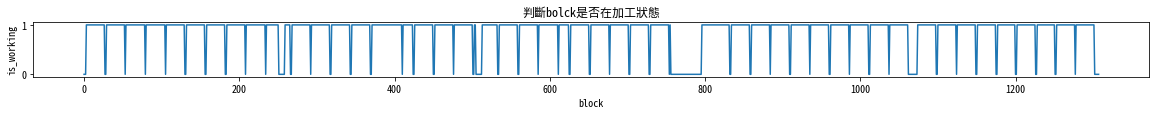

In [3]:
g_z=g_zrise=0
isWorkingIndex=[]
for blk in data.plc:
    ret, g_z, g_zrise = isworkingChk(blk, g_z, g_zrise)
    isWorkingIndex.append(ret)
    
isWorkingIndex = np.array(isWorkingIndex)
unique, counts = np.unique(isWorkingIndex, return_counts=True)
print('加工/非加工Block數量',dict(zip(unique, counts)))
plt.figure(figsize=(20,1))
plt.plot(isWorkingIndex)
plt.xlabel('block')
plt.ylabel('is_working')
plt.title('判斷block是否在加工狀態');


### Featuring
- Time Domain
    - RMS

- Frequency Domain
    - K-Order RMS

- Wavelet
    - S = An + Dn + Dn-1 + ... + D1
    - 對每一個傳感器數據塊做4階小波轉換
    - 對小波轉換之後的每一階取RMS

In [4]:



col='Spindle_S01'
# time domain rms
print('time domain rms feature')
rms_list = list(map(lambda x: getrms(x), data.sensor[col]))

# wavelet rms
a_rms = []
d_rms = []
print('wavelet rms features...')
for blk in tqdm(data.sensor[col]):
    rec_a, rec_d = wavelet(blk)
    rec_a_rms = list(map(lambda x:getrms(x), rec_a))
    rec_d_rms = list(map(lambda x:getrms(x), rec_d))
    a_rms.append(rec_a_rms)
    d_rms.append(rec_d_rms)
a1rms,a2rms,a3rms,a4rms = zip(*a_rms)
d1rms,d2rms,d3rms,d4rms = zip(*d_rms)    
wvfeatures = pd.DataFrame([d1rms,d2rms,d3rms,d4rms,a4rms]).T
wvfeatures.columns=['d1_rms','d2_rms','d3_rms','d4_rms','a4_rms']


# frequency domain rms
orderrmslist=[]
ordernum=6
print('order rms features...')
for blk in tqdm(data.sensor[col]):
    orderrms = getorderrms(blk, ordernum)
    orderrmslist.append(orderrms)
orderfeatures = pd.DataFrame(orderrmslist)
orderfeatures.columns=list(map(lambda x: 'o{}_rms'.format(x), range(1,ordernum)))

features = pd.concat([wvfeatures, orderfeatures], axis=1, sort=False)
features['raw_rms'] = rms_list
for i in np.where(features.isnull().any(axis=1))[0]:
    isWorkingIndex[i]=False
features.fillna(method='backfill', inplace=True)



time domain rms feature
wavelet rms features...



order rms features...


/usr/local/lib/python3.6/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 2560 is greater than input length  = 2150, using nperseg = 2150
  .format(nperseg, input_length))


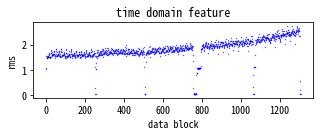

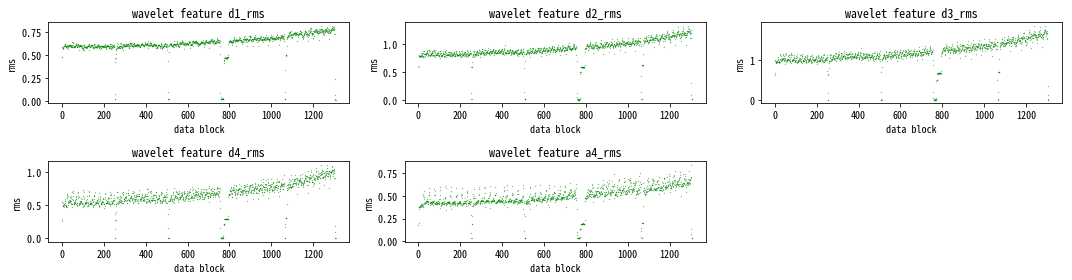

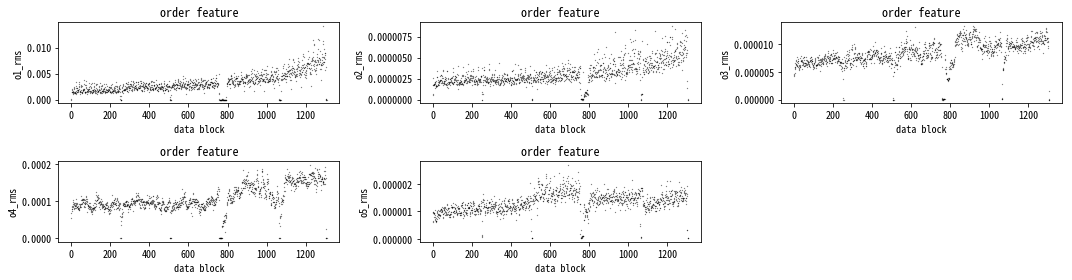

In [5]:
#Visualize
plt.figure(figsize=(4.6,2))
plt.plot(rms_list, 'b.', ms=0.6)
plt.xlabel('data block')
plt.ylabel('rms')
plt.title('time domain feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,4))
for idx, c in enumerate(wvfeatures.columns):
    plt.subplot(231+idx)
    plt.plot(wvfeatures[c].values, 'g.', ms=0.4)
    plt.xlabel('data block')
    plt.ylabel('rms')
    plt.title(f'wavelet feature {c}')
plt.tight_layout()

plt.figure(figsize=(15,4))
for idx, c in enumerate(orderfeatures.columns):
    plt.subplot(231+idx)
    plt.plot(orderfeatures[c].values, 'k.', ms=0.4)
    plt.xlabel('data block')
    plt.ylabel(c)
    plt.title('order feature')
plt.tight_layout()



### Build GMM Model

best gmm model:
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200,
                means_init=None, n_components=2, n_init=3, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=1e-05, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


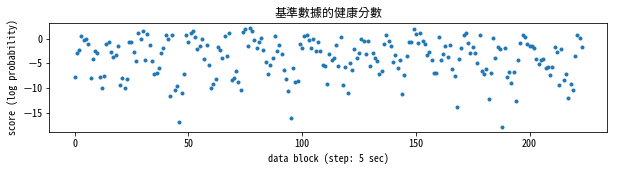

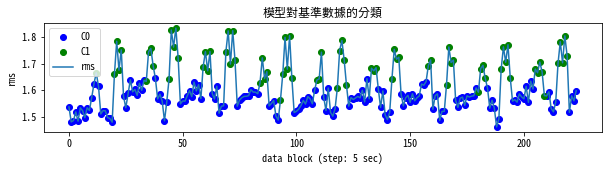

In [8]:



baseStart = 0
baseEnd=int(20*60/5) #用20分鐘數據當作基準 
wkidx = np.where(isWorkingIndex[baseStart:baseEnd]==1)[0]

basefeatures = features[baseStart:baseEnd].iloc[wkidx]
#print(features[baseStart:baseEnd].shape, validfeatures.shape)
#Normalize
scaler = StandardScaler()
basefeatures_normalized = scaler.fit_transform(basefeatures) #這邊已經過濾掉非加工數據


X = basefeatures_normalized
clf = getbestGMM(X)
clf = clf.fit(X)
score = clf.score_samples(X)
clspreds = clf.predict(X)

plt.figure(figsize=(10,2))
plt.plot(score,'.')
plt.title('基準數據的健康分數')
plt.xlabel('data block (step: 5 sec)')
plt.ylabel('score (log probability)')
plt.show()


baserms = np.array(rms_list)[baseStart:baseEnd][wkidx]
plt.figure(figsize=(10,2))
colr =['bo', 'go', 'ro', 'co', 'mo', 'yo', 'ko', 'wo']
for cls in range(clf.n_components):
    x = np.where(clspreds==cls)[0]
    y = baserms[x]
    plt.plot(x,y,colr[cls],label='C{}'.format(cls))
    
plt.plot(baserms,label='rms')    
plt.legend()
plt.xlabel('data block (step: 5 sec)')
plt.ylabel('rms')
plt.title('模型對基準數據的分類')
plt.show()



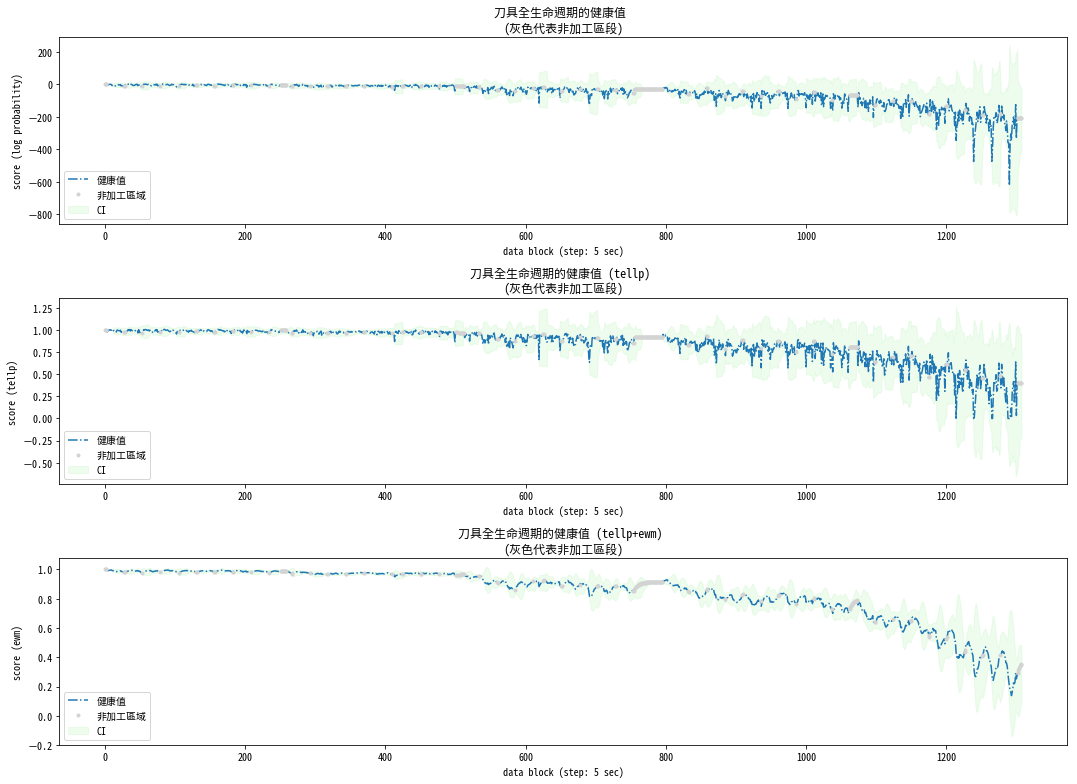

In [11]:
def plotCI(data):
    df = pd.DataFrame(data)
    smooth = df.rolling(60//5).mean()
    dev = 2 * df.rolling(60//5).std()
    plt.fill_between(dev.index, (smooth-2*dev)[0], (smooth+2*dev)[0], color='lightgreen', alpha=0.15, label='CI')    


nwkidx = np.where(isWorkingIndex==0)[0]
features_normalized = scaler.transform(features)

X_all = features_normalized
score = clf.score_samples(X_all)
for i in nwkidx:
    score[i]=0 if (i-1)<0 else score[i-1]

tellp = np.array(list(map(lambda x: 1- np.log(np.exp(x)+1e-150)/(np.log(1e-150)), score)))
tellpewm = pd.Series(tellp).ewm(span=60/5).mean()
    
plt.figure(figsize=(15,11))
plt.subplot(311)
plt.plot(score,'-.', label='健康值')
plt.plot(nwkidx, score[nwkidx], 'lightgray', marker='.',linestyle="None", label='非加工區域')
plotCI(score)
plt.xlabel('data block (step: 5 sec)')
plt.ylabel('score (log probability)')
plt.legend(loc=3)
plt.title('刀具全生命週期的健康值 \n(灰色代表非加工區段)')

plt.subplot(312)
plt.plot(tellp,'-.', label='健康值')
plt.plot(nwkidx, tellp[nwkidx], 'lightgray', marker='.',linestyle="None", label='非加工區域' )
plotCI(tellp)
plt.xlabel('data block (step: 5 sec)')
plt.ylabel('score (tellp)')
plt.legend(loc=3)
plt.title('刀具全生命週期的健康值 (tellp) \n(灰色代表非加工區段)')


plt.subplot(313)
plt.plot(tellpewm,'-.', label='健康值')
plt.plot(nwkidx, tellpewm[nwkidx], 'lightgray', marker='.',linestyle="None", label='非加工區域' )
plotCI(tellpewm)
plt.xlabel('data block (step: 5 sec)')
plt.ylabel('score (ewm)')
plt.legend(loc=3)
plt.title('刀具全生命週期的健康值 (tellp+ewm) \n(灰色代表非加工區段)')
plt.tight_layout()
plt.show()

